Name: **Shahid Ali Khowaja**

Student ID: **23034289**

In [138]:
#!pip install --upgrade --force-reinstall pandas==2.2.2 numpy==1.26.4 tensorflow==2.18.0 numba==0.60.0

In [139]:
!pip install pmdarima

In [140]:
# import libaraies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.optimizers import Adam
import warnings
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima


In [141]:
warnings.filterwarnings("ignore")

In [142]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
# import data from My Drive
df_nvidia = pd.read_csv("/content/drive/MyDrive/NVIDIA_STOCK.csv")

In [144]:
# Display the dataframe
df_nvidia.head()

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-02,4.929879665374756,4.983749866485596,4.987500190734863,4.862500190734863,4.894499778747559,355616000
3,2018-01-03,5.254334926605225,5.3117499351501465,5.34250020980835,5.09375,5.102499961853027,914704000
4,2018-01-04,5.2820329666137695,5.339749813079834,5.451250076293945,5.317249774932861,5.394000053405762,583268000


In [145]:
# display information
df_nvidia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1699 non-null   object
 1   Adj Close  1698 non-null   object
 2   Close      1698 non-null   object
 3   High       1698 non-null   object
 4   Low        1698 non-null   object
 5   Open       1698 non-null   object
 6   Volume     1698 non-null   object
dtypes: object(7)
memory usage: 93.0+ KB


In [146]:
# Data Cleaning
# Remove unwanted rows
df_nvidia = df_nvidia.iloc[2:]
# Remove rows with missing values
df_nvidia = df_nvidia.dropna()

In [147]:
# Convert object into float
df_nvidia[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']] = df_nvidia[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].astype(float)

In [148]:
# Handle missing values
df_nvidia.ffill(inplace=True)

In [149]:
# Convert date column to datetime
df_nvidia.rename(columns={'Price': 'Date'}, inplace=True)
df_nvidia['Date'] = pd.to_datetime(df_nvidia['Date'])
df_nvidia = df_nvidia.sort_values(by="Date").reset_index(drop=True)

In [150]:
# Display summary
df_nvidia.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2018-01-02,4.929880,4.98375,4.98750,4.86250,4.89450,355616000.0
1,2018-01-03,5.254335,5.31175,5.34250,5.09375,5.10250,914704000.0
2,2018-01-04,5.282033,5.33975,5.45125,5.31725,5.39400,583268000.0
3,2018-01-05,5.326794,5.38500,5.42275,5.27700,5.35475,580124000.0
4,2018-01-08,5.490012,5.55000,5.62500,5.46450,5.51000,881216000.0


In [151]:
# display information
df_nvidia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697 entries, 0 to 1696
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1697 non-null   datetime64[ns]
 1   Adj Close  1697 non-null   float64       
 2   Close      1697 non-null   float64       
 3   High       1697 non-null   float64       
 4   Low        1697 non-null   float64       
 5   Open       1697 non-null   float64       
 6   Volume     1697 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 92.9 KB


In [152]:
# Missing values
df_nvidia.isna().sum()

,0
Date,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [153]:
# Duplicated values
df_nvidia.duplicated().sum()

0

In [154]:
# Summary statistics
df_nvidia.describe()

,Date,Adj Close,Close,High,Low,Open,Volume
count,1697,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1.697000e+03
mean,2021-05-16 04:49:21.461402368,24.797593,24.828411,25.295239,24.315422,24.823341,4.716865e+08
min,2018-01-02 00:00:00,3.151430,3.177000,3.249500,3.111500,3.162250,9.788400e+07
25%,2019-09-10 00:00:00,6.113620,6.161750,6.250000,6.064250,6.166250,3.278440e+08
50%,2021-05-17 00:00:00,13.985092,14.015750,14.243500,13.750000,14.033750,4.349650e+08
75%,2023-01-23 00:00:00,27.088902,27.104000,27.496000,26.613001,27.077999,5.708320e+08
max,2024-09-30 00:00:00,135.559067,135.580002,140.759995,132.419998,139.800003,2.511528e+09
std,NaN,29.221442,29.216014,29.811740,28.570804,29.240504,2.093254e+08


In [155]:
# display correlation
df_nvidia.corr()

,Date,Adj Close,Close,High,Low,Open,Volume
Date,1.000000,0.766104,0.765909,0.765275,0.766219,0.765174,-0.105869
Adj Close,0.766104,1.000000,1.000000,0.999662,0.999763,0.999329,-0.113866
Close,0.765909,1.000000,1.000000,0.999662,0.999763,0.999330,-0.113864
High,0.765275,0.999662,0.999662,1.000000,0.999673,0.999780,-0.109508
Low,0.766219,0.999763,0.999763,0.999673,1.000000,0.999668,-0.117262
Open,0.765174,0.999329,0.999330,0.999780,0.999668,1.000000,-0.112821
Volume,-0.105869,-0.113866,-0.113864,-0.109508,-0.117262,-0.112821,1.000000


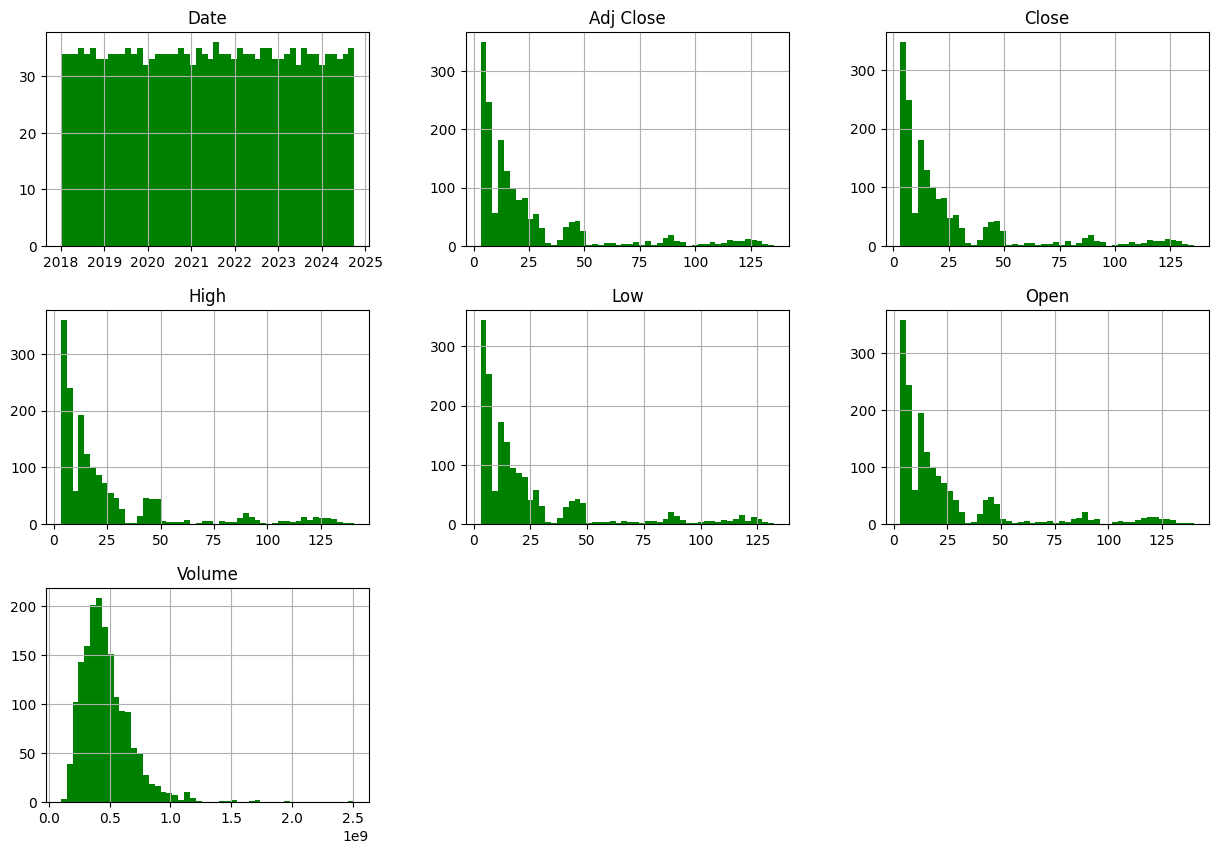

In [156]:
#histogram
df_nvidia.hist(bins=50, color="green", figsize=(15,10))
plt.savefig('nvidia-histrogram.png')
plt.show()

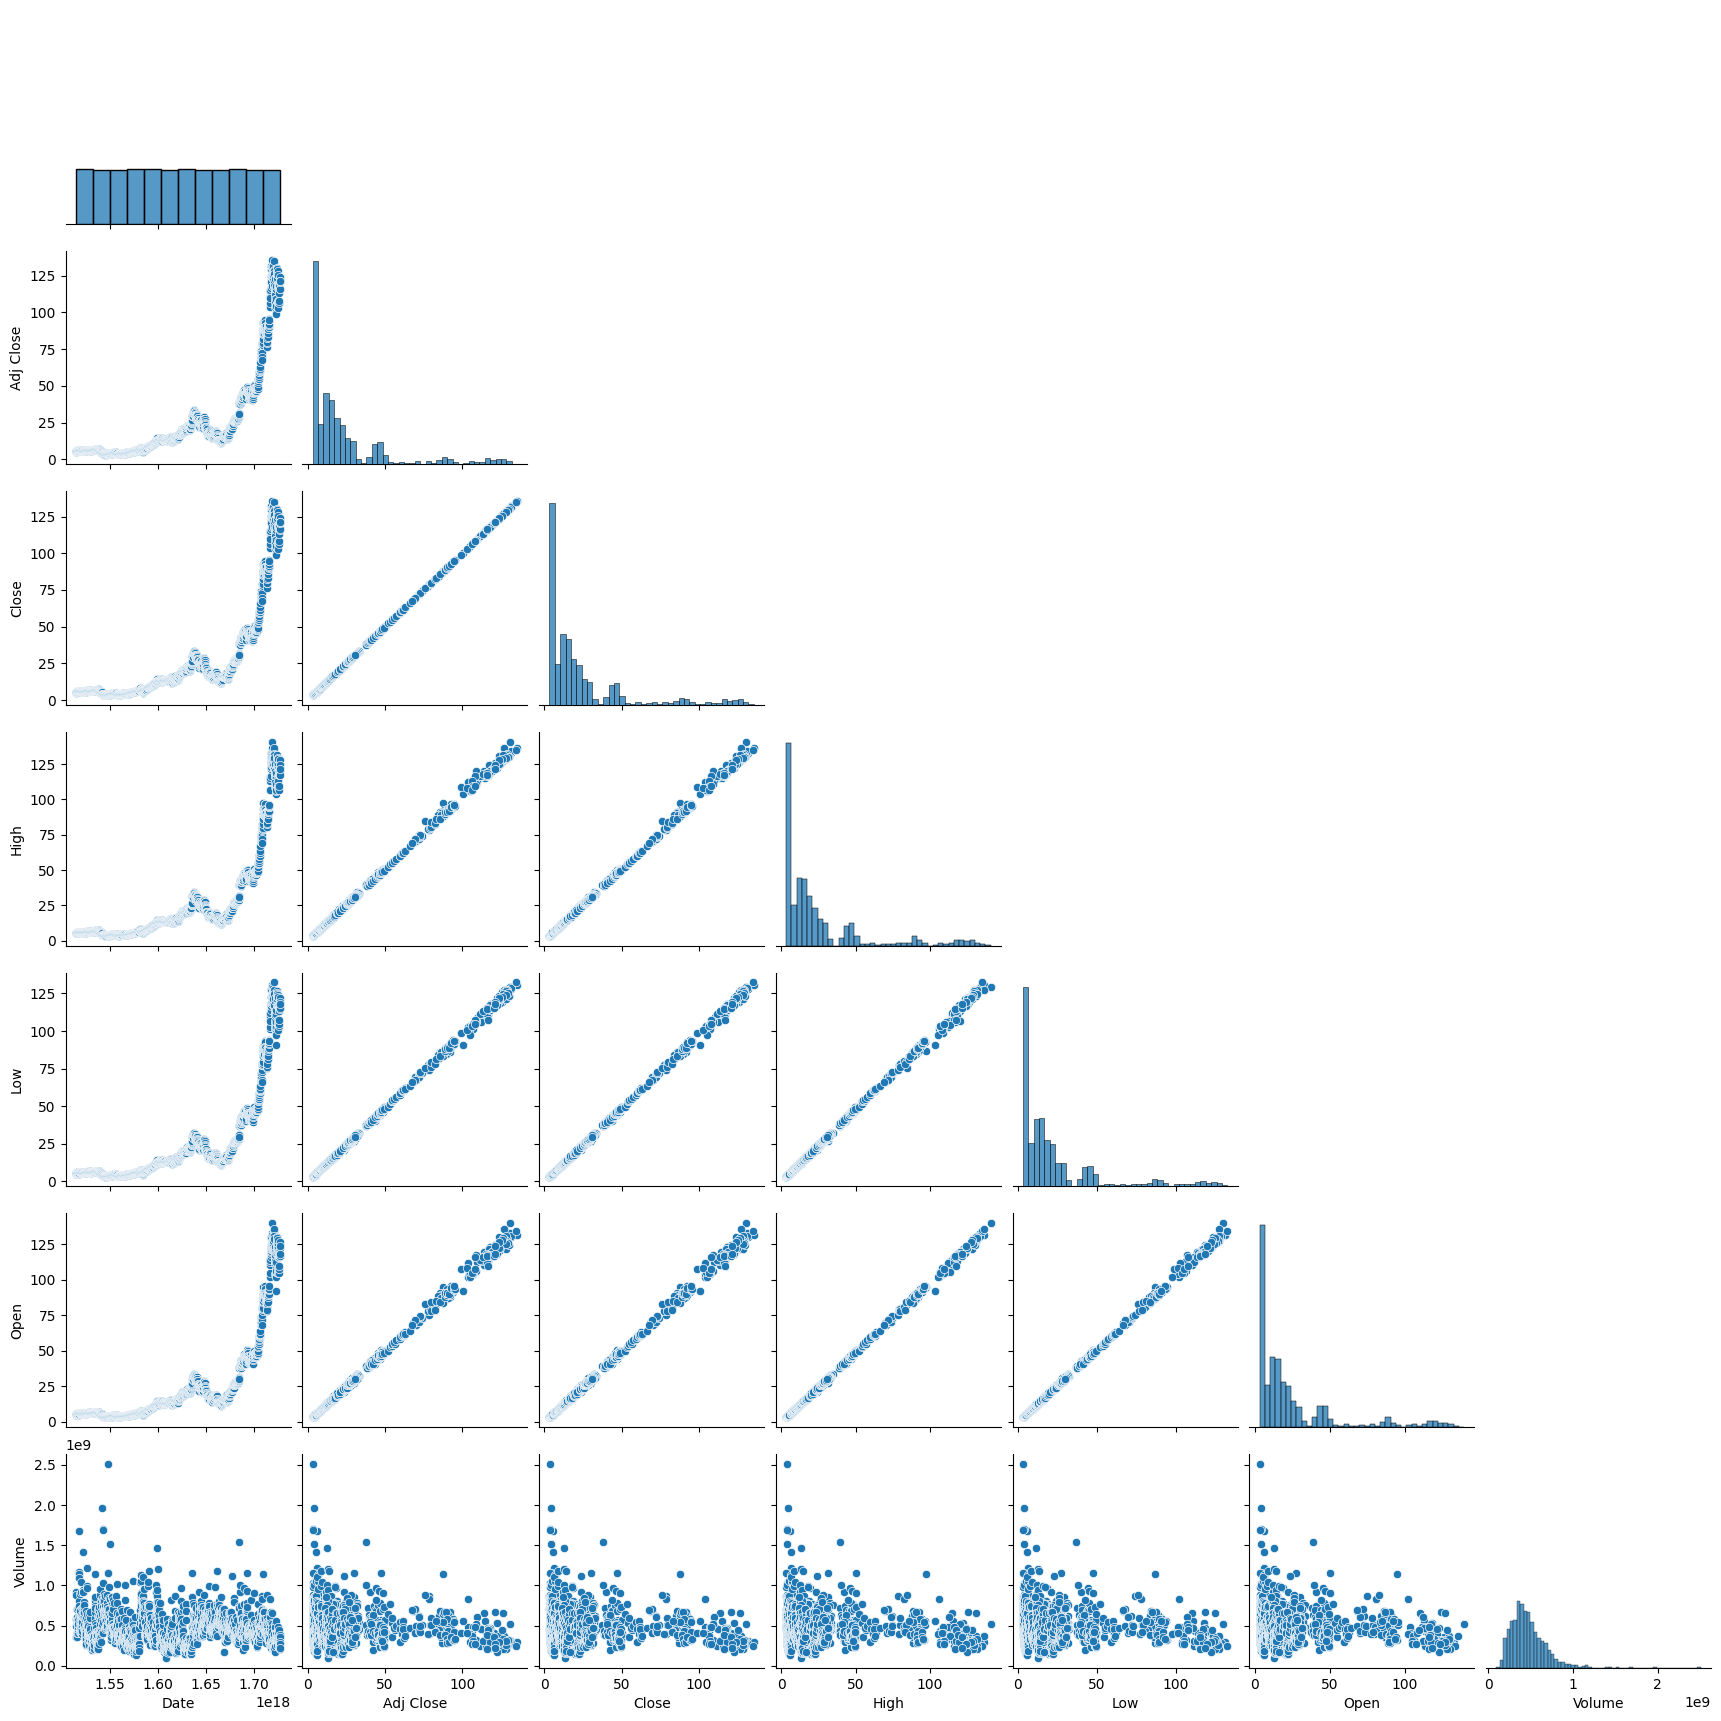

In [157]:
# Looking at some real data, where we don't know the number of clusters already
for col in df_nvidia.columns:
    df_nvidia[col] = pd.to_numeric(df_nvidia[col])

sns.pairplot(df_nvidia, corner=True)
plt.savefig('nvidia-cluster.png')
plt.show()

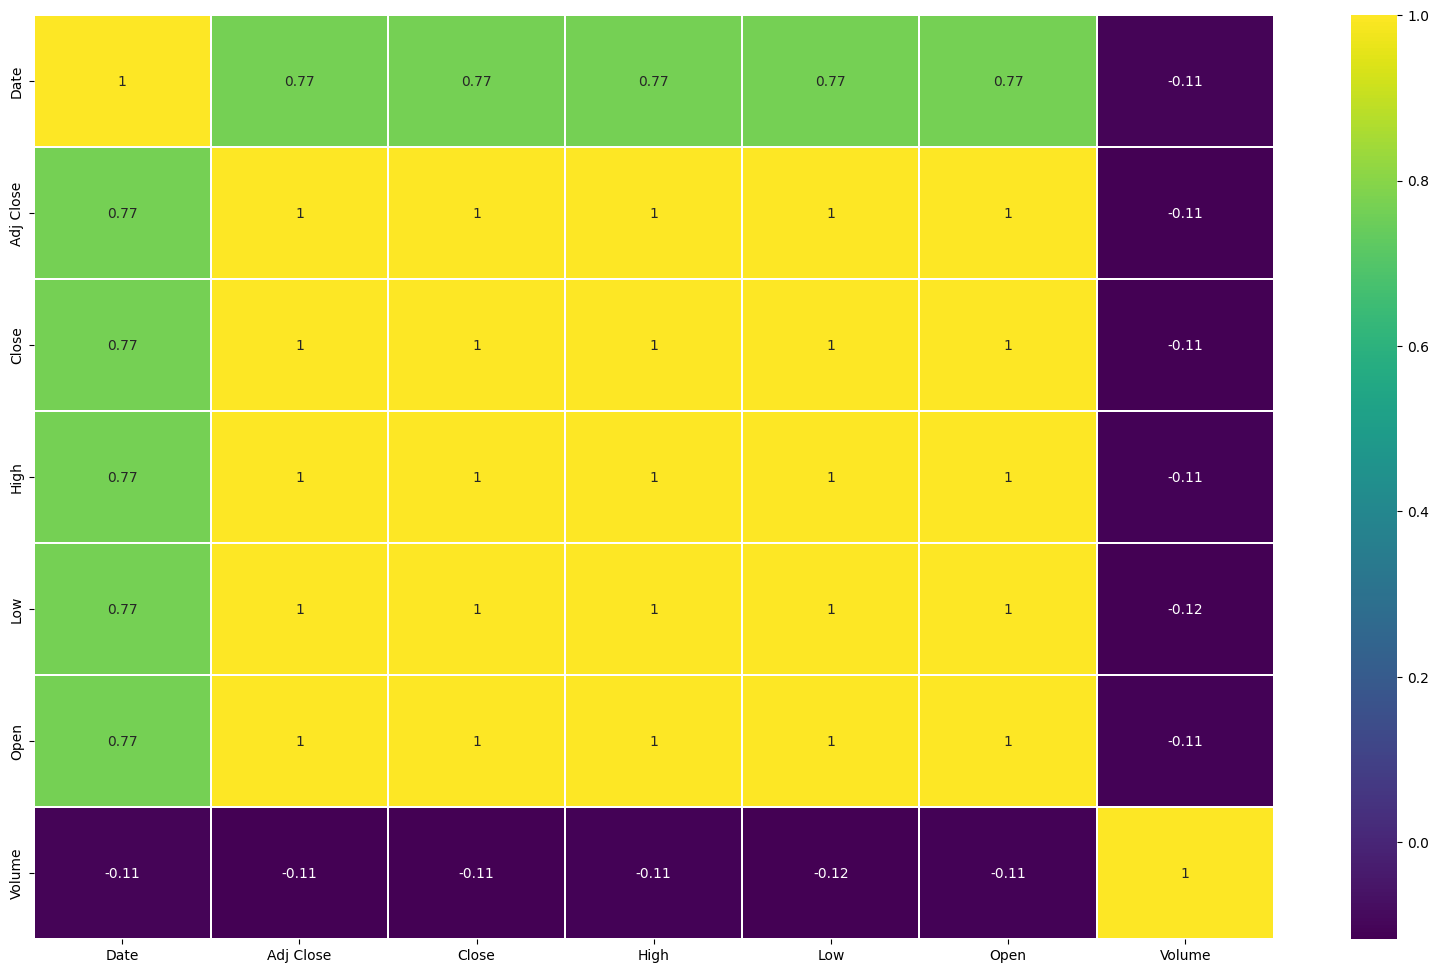

In [158]:
# Show correlation
fig, ax = plt.subplots(figsize = (20, 12))
ax = sns.heatmap(df_nvidia.corr(), cmap='viridis', cbar=True, annot=True, linewidths=0.2,ax=ax)
# save image
plt.savefig('nvidia-corr.png')
plt.show()

In [159]:
if df_nvidia.index.name == "Date":
    df_nvidia = df_nvidia.reset_index()

In [160]:
# Feature Engineering (Moving Averages and Volatility)

# Calculate the 50-day Simple Moving Average (SMA), which smooths the closing price by averaging it over the last 50 days to identify short-term trends.
df_nvidia['SMA_50'] = df_nvidia['Close'].rolling(window=50).mean()

# Calculate the 200-day Simple Moving Average (SMA), which smooths the closing price over the last 200 days to identify long-term trends.
df_nvidia['SMA_200'] = df_nvidia['Close'].rolling(window=200).mean()

# Calculate the 50-day rolling standard deviation (Volatility), which measures the dispersion of closing prices over the last 50 days, indicating market volatility.
df_nvidia['Volatility'] = df_nvidia['Close'].rolling(window=50).std()

df_nvidia.dropna(inplace=True)

In [161]:
# Display the dataframe
df_nvidia.head()

,Date,Adj Close,Close,High,Low,Open,Volume,SMA_50,SMA_200,Volatility
199,1539648000000000000,6.090191,6.14575,6.15700,5.94850,5.99825,408712000.0,6.656860,6.178069,0.321654
200,1539734400000000000,6.021566,6.07650,6.24700,6.02700,6.20850,329668000.0,6.649915,6.183533,0.330420
201,1539820800000000000,5.934114,5.98825,6.18525,5.92725,6.14650,524020000.0,6.640470,6.186915,0.342474
202,1539907200000000000,5.677456,5.72925,6.06375,5.69250,6.04400,613608000.0,6.626825,6.188863,0.364656
203,1540166400000000000,5.728243,5.78050,5.88300,5.67675,5.78200,368844000.0,6.615040,6.190840,0.382232


In [162]:
# Convert "Date" to datetime format
df_nvidia["Date"] = pd.to_datetime(df_nvidia["Date"], errors='coerce')

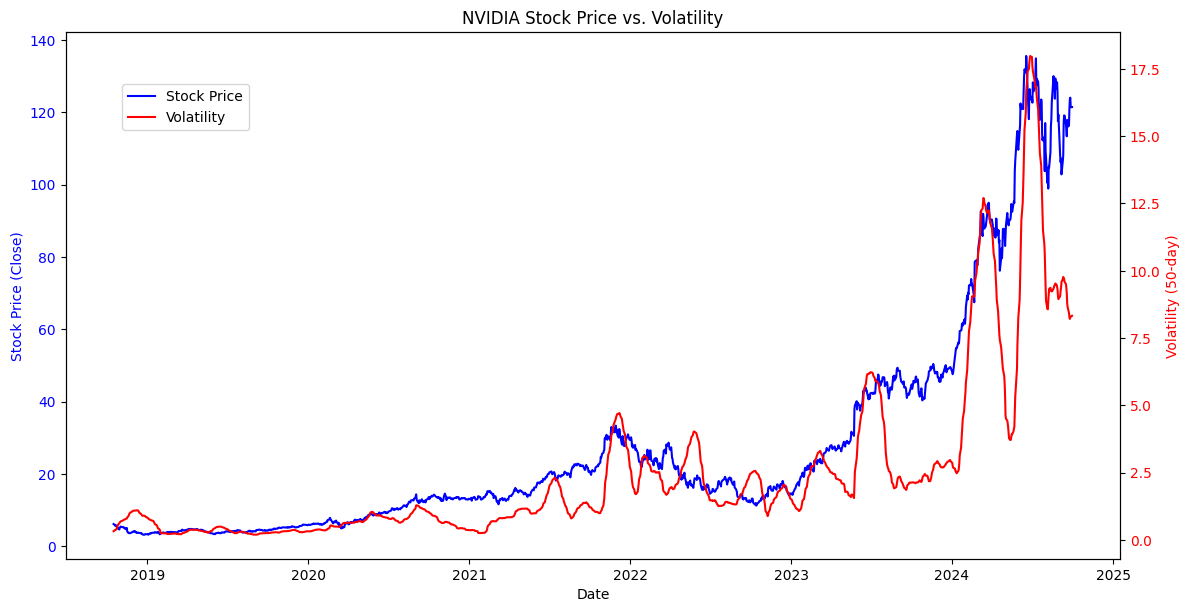

In [163]:
# Plot stock price and volatility
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot stock price
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price (Close)", color="blue")
line1, = ax1.plot(df_nvidia["Date"], df_nvidia["Close"], label="Stock Price", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Create second y-axis for volatility
ax2 = ax1.twinx()
ax2.set_ylabel("Volatility (50-day)", color="red")
line2, = ax2.plot(df_nvidia["Date"], df_nvidia["Volatility"], label="Volatility", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Combine legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Final formatting
fig.tight_layout()
plt.title("NVIDIA Stock Price vs. Volatility")
plt.savefig('nvidia-stock-price-volatility.png')
plt.show()

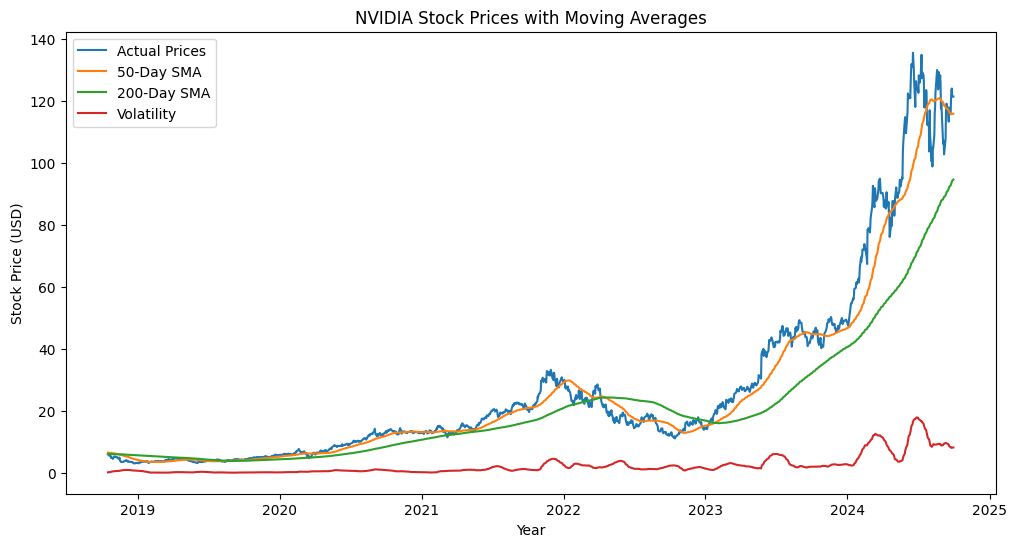

In [164]:
plt.figure(figsize=(12, 6))
plt.plot(df_nvidia["Date"], df_nvidia["Close"], label="Actual Prices")
plt.plot(df_nvidia["Date"], df_nvidia["SMA_50"], label="50-Day SMA")
plt.plot(df_nvidia["Date"], df_nvidia["SMA_200"], label="200-Day SMA")
plt.plot(df_nvidia["Date"], df_nvidia["Volatility"], label="Volatility")

plt.title("NVIDIA Stock Prices with Moving Averages")
plt.xlabel("Year")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.savefig('nvidia-stock-price-moving-average.png')
plt.show()

In [165]:
# Define features and target
features = ['Adj Close', 'High', 'Low', 'Open', 'Volume', 'SMA_50', 'SMA_200', 'Volatility']
target = 'Close'

In [166]:
# Scale data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [167]:
# Create lag sequences
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i - seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

**LSTM DAILY PREDICTIONS**

In [168]:
X_scaled = scaler_X.fit_transform(df_nvidia[features])
y_scaled = scaler_y.fit_transform(df_nvidia[[target]])

sequence_length = 60  # using the last 60 days to predict the next day
X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

# For time series we preserve order (no random shuffling)
train_size = int(0.8 * len(X_seq))
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_test  = X_seq[train_size:]
y_test  = y_seq[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='loss', patience=15, min_delta=0.0001, restore_best_weights=True, verbose=1)

# Train model
history_daily = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Predict on the test set
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - loss: 0.0043 - val_loss: 0.0161
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 7.0602e-04 - val_loss: 0.0033
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - loss: 5.5699e-04 - val_loss: 0.0035
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 4.7528e-04 - val_loss: 0.0034
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 4.6306e-04 - val_loss: 0.0033
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - loss: 4.7840e-04 - val_loss: 0.0029
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - loss: 4.1286e-04 - val_loss: 0.0029
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 3.7983e-04 - val_loss: 0.0030
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - loss: 3.7329e-04 - val_loss: 0.0028
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 3.4002e-04 - val_loss: 0.0027
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - loss: 2.9804e-04 - val_loss: 0.0026

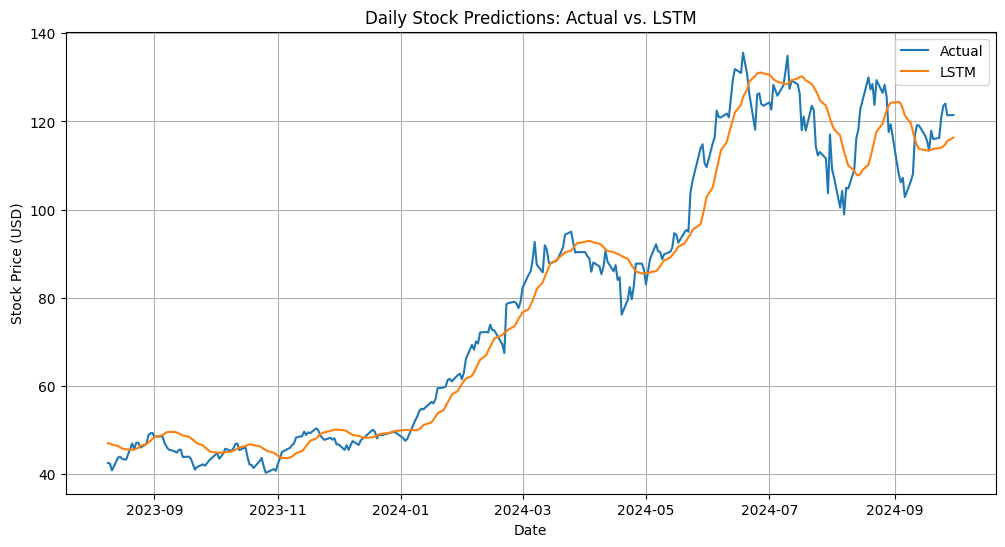

In [169]:
# Plot comparison for daily predictions
dates_daily = df_nvidia['Date'][train_size + sequence_length : len(df_nvidia)]

plt.figure(figsize=(12, 6))
plt.plot(dates_daily, y_actual.flatten(), label='Actual')
plt.plot(dates_daily, y_pred.flatten(), label='LSTM')
plt.title("Daily Stock Predictions: Actual vs. LSTM")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.savefig('nvidia-lstm-daily-predication.png')
plt.show()

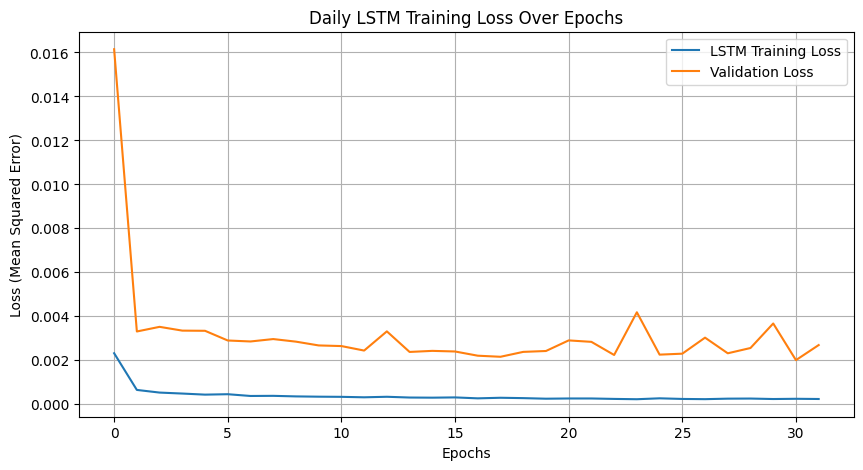

In [170]:
# Plot training Loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history_daily.history['loss'], label="LSTM Training Loss")
plt.plot(history_daily.history['val_loss'], label='Validation Loss')

# Customize the Plot
plt.xlabel("Epochs")
plt.ylabel("Loss (Mean Squared Error)")
plt.title("Daily LSTM Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.savefig('nvidia-lstm-daily-loss-epochs.png')
plt.show()

**LSTM WEEKLY PREDICTIONS**

In [171]:
# Resample the data to weekly frequency (taking the last trading day of each week)
df_weekly = df_nvidia.set_index('Date').resample('W').last().reset_index()

# Scale weekly data
X_week_scaled = scaler_X.fit_transform(df_weekly[features])
y_week_scaled = scaler_y.fit_transform(df_weekly[[target]])

# Create sequences for weekly data
seq_length_week = 4  # for example, use 4 weeks to predict the next week
X_week_seq, y_week_seq = create_sequences(X_week_scaled, y_week_scaled, seq_length_week)

# Split preserving order
train_size_week = int(0.8 * len(X_week_seq))
X_week_train = X_week_seq[:train_size_week]
y_week_train = y_week_seq[:train_size_week]
X_week_test  = X_week_seq[train_size_week:]
y_week_test  = y_week_seq[train_size_week:]

# Build and train the weekly LSTM model
model_week = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_week_train.shape[1], X_week_train.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])
model_week.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

early_stopping_week = EarlyStopping(monitor='loss', patience=10, min_delta=0.0001, restore_best_weights=True, verbose=1)

history_week = model_week.fit(X_week_train, y_week_train, epochs=100, batch_size=32, validation_data=(X_week_test, y_week_test), callbacks=[early_stopping_week], verbose=1)

# Weekly predictions
y_week_pred_scaled = model_week.predict(X_week_test)
y_week_pred = scaler_y.inverse_transform(y_week_pred_scaled)
y_week_actual = scaler_y.inverse_transform(y_week_test)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0144 - val_loss: 0.3774
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0108 - val_loss: 0.3127
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0060 - val_loss: 0.2558
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0053 - val_loss: 0.2033
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0040 - val_loss: 0.1601
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0037 - val_loss: 0.1255
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0028 - val_loss: 0.1000
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022 - val_loss: 0.0825
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0019 - val_loss: 0.0693
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0017 - val_loss: 0.0579
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015 - val_loss: 0.0475
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015 - val_lo

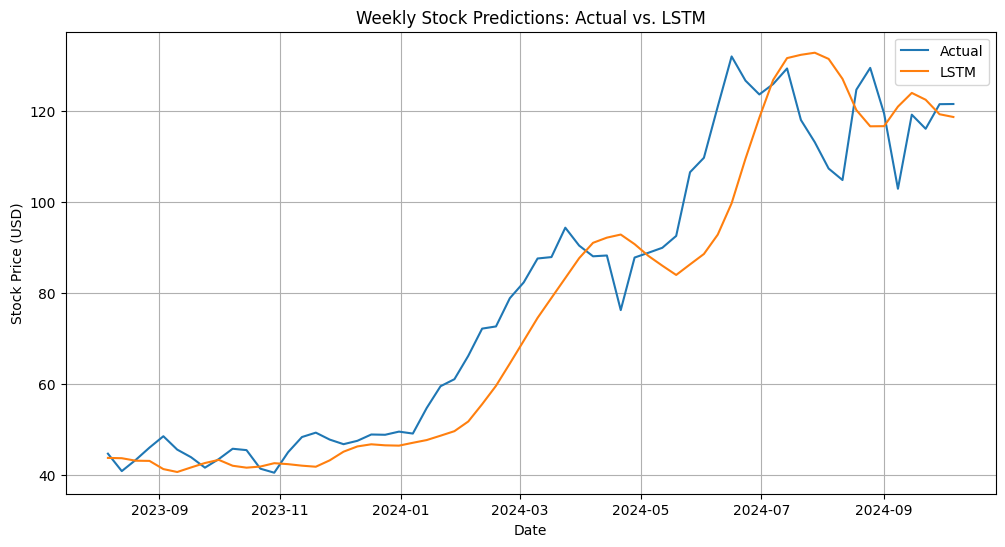

In [172]:
# Plot weekly results
dates_weekly = df_weekly['Date'][train_size_week + seq_length_week : len(df_weekly)]
plt.figure(figsize=(12, 6))
plt.plot(dates_weekly, y_week_actual, label='Actual')
plt.plot(dates_weekly, y_week_pred, label='LSTM')
plt.title("Weekly Stock Predictions: Actual vs. LSTM")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.savefig('nvidia-lstm-weekly-predication.png')
plt.show()

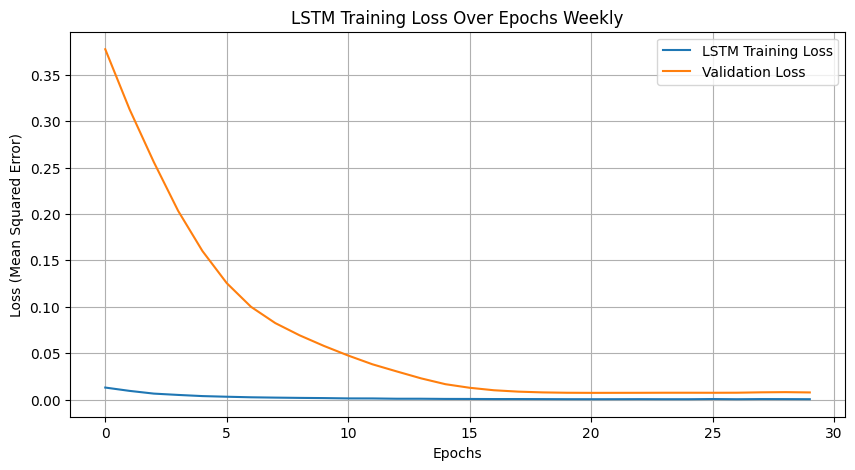

In [173]:
# Plot training Loss over epochs Weekly
plt.figure(figsize=(10, 5))
plt.plot(history_week.history['loss'], label="LSTM Training Loss")
plt.plot(history_week.history['val_loss'], label='Validation Loss')

# Customize the Plot
plt.xlabel("Epochs")
plt.ylabel("Loss (Mean Squared Error)")
plt.title("LSTM Training Loss Over Epochs Weekly")
plt.legend()
plt.grid(True)
plt.savefig('nvidia-lstm-weekly-loss-epochs.png')
plt.show()

In [174]:
# Linear Regression
X_train_lr = X_train.reshape(X_train.shape[0], -1)  # Flatten 3D → 2D
X_test_lr = X_test.reshape(X_test.shape[0], -1)

# Train Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_lr, y_train)
y_pred_lr = linear_model.predict(X_test_lr)

# Inverse transform predictions and actual values
y_pred_lr_inv = scaler_y.inverse_transform(y_pred_lr)
y_actual_lr_inv = scaler_y.inverse_transform(y_test)

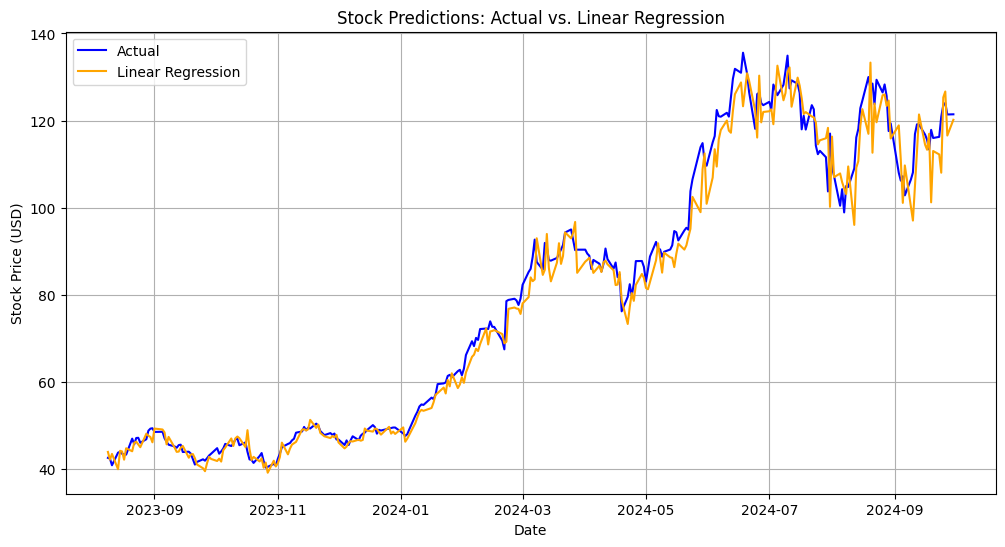

In [175]:
# Plot comparison for Linear Regression
dates_daily = df_nvidia['Date'][train_size + sequence_length : len(df_nvidia)]

plt.figure(figsize=(12, 6))
plt.plot(dates_daily, y_actual.flatten(), label='Actual', color='blue')
plt.plot(dates_daily, y_pred_lr_inv.flatten(), label='Linear Regression', color='orange')
plt.title("Stock Predictions: Actual vs. Linear Regression")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.savefig('nvidia-linear-regression-predication.png')
plt.show()

In [176]:
# Flatten for Random Forest
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)

# Train Random Forest
random_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_model.fit(X_train_rf, y_train)
y_pred_rf = random_model.predict(X_test_rf)

# Inverse transform predictions and targets
y_pred_rf_inv = scaler_y.inverse_transform(y_pred_rf.reshape(-1, 1))
y_actual_rf_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

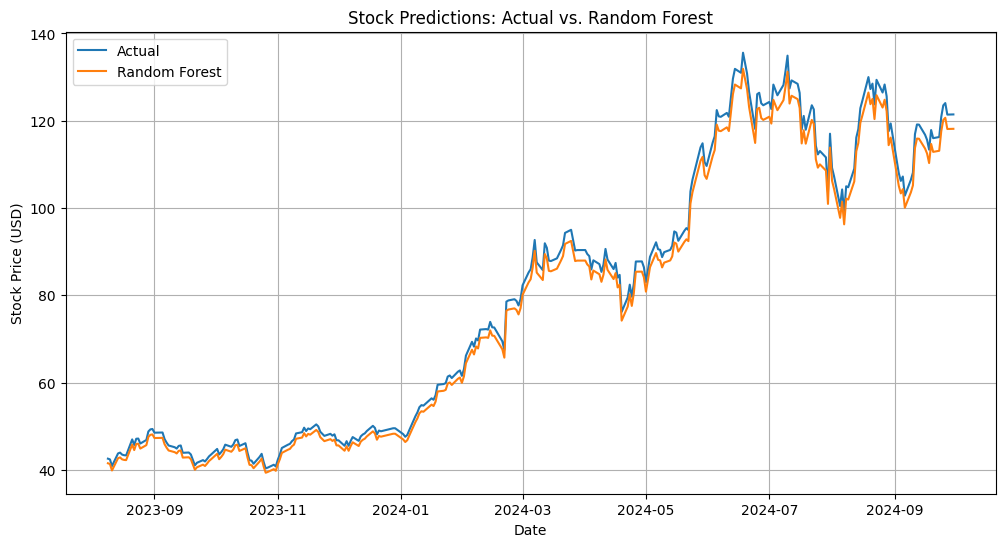

In [177]:
# Plot comparison for daily predictions
dates_daily = df_nvidia['Date'][train_size + sequence_length : len(df_nvidia)]

plt.figure(figsize=(12, 6))
plt.plot(dates_daily, y_actual.flatten(), label='Actual')
plt.plot(dates_daily, y_actual_rf_inv.flatten(), label='Random Forest')
plt.title("Stock Predictions: Actual vs. Random Forest")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.savefig('nvidia-random-forest-predication.png')
plt.show()

In [178]:
from pmdarima import auto_arima
# Train-test split (80/20)
train_size = int(len(df_nvidia) * 0.8)
train, test = df_nvidia['Close'][:train_size], df_nvidia['Close'][train_size:]

# Auto ARIMA to select best (p,d,q)
auto_model = auto_arima(train, seasonal=False, stepwise=True, trace=False, suppress_warnings=True)
best_order = auto_model.order
print(f"Best ARIMA Order: ({best_order})")

# Train ARIMA model with best order
arima_model = ARIMA(train, order=best_order)
fitted_model = arima_model.fit()

# Forecast
forecast = fitted_model.forecast(steps=len(test))

Best ARIMA Order: ((2, 1, 2))


In [179]:
df_nvidia.head()

,Date,Adj Close,Close,High,Low,Open,Volume,SMA_50,SMA_200,Volatility
199,2018-10-16,6.090191,6.14575,6.15700,5.94850,5.99825,408712000.0,6.656860,6.178069,0.321654
200,2018-10-17,6.021566,6.07650,6.24700,6.02700,6.20850,329668000.0,6.649915,6.183533,0.330420
201,2018-10-18,5.934114,5.98825,6.18525,5.92725,6.14650,524020000.0,6.640470,6.186915,0.342474
202,2018-10-19,5.677456,5.72925,6.06375,5.69250,6.04400,613608000.0,6.626825,6.188863,0.364656
203,2018-10-22,5.728243,5.78050,5.88300,5.67675,5.78200,368844000.0,6.615040,6.190840,0.382232


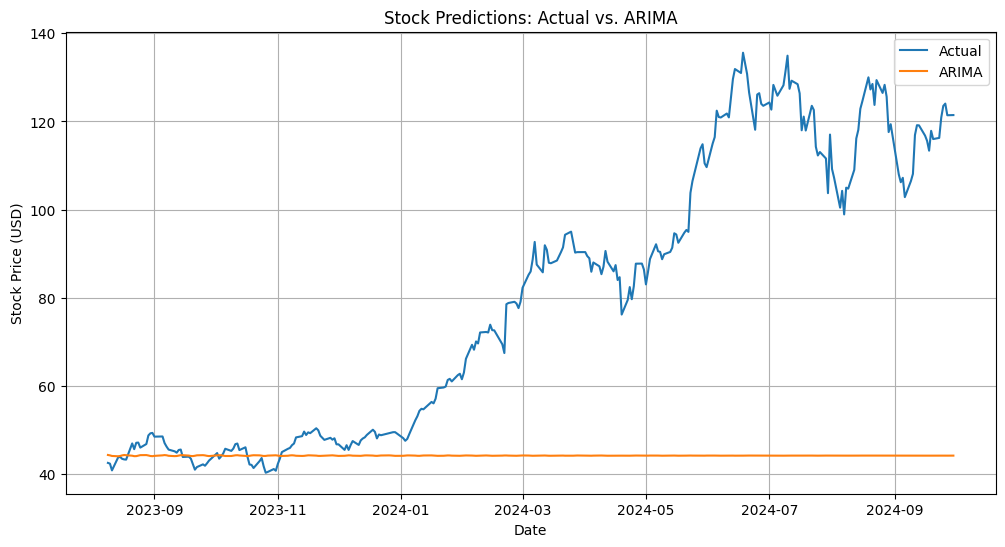

In [180]:
# Plot comparison for daily predictions
dates_arima = df_nvidia['Date'][-len(y_actual):]

plt.figure(figsize=(12, 6))
plt.plot(dates_arima, y_actual.flatten(), label='Actual')
plt.plot(dates_arima, forecast[:len(y_actual)], label='ARIMA')
plt.title("Stock Predictions: Actual vs. ARIMA")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.savefig('nvidia-arima-stock-predication.png')
plt.show()

In [181]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return model_name, round(mae, 4), round(rmse, 4), round(r2, 4)

+-------------------+---------+---------+------------+
| Model             |     MAE |    RMSE |   R² Score |
+===================+=========+=========+============+
| Linear Regression |  2.6547 |  4.0176 |     0.9823 |
+-------------------+---------+---------+------------+
| Random Forest     | 34.1292 | 45.2188 |    -1.2401 |
+-------------------+---------+---------+------------+
| LSTM Daily        |  4.6995 |  6.2245 |     0.9599 |
+-------------------+---------+---------+------------+
| LSTM Weekly       |  8.1223 | 11.1079 |     0.8747 |
+-------------------+---------+---------+------------+
| ARIMA             | 34.4113 | 46.1709 |    -1.1905 |
+-------------------+---------+---------+------------+


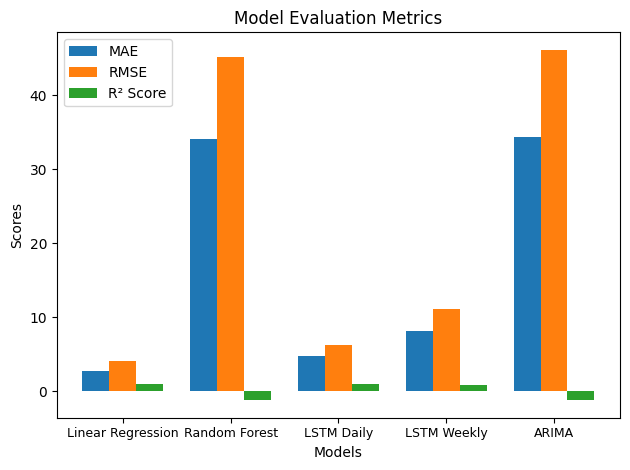

In [182]:
from tabulate import tabulate

# Define the evaluation metrics data
results = [
    evaluate_model(np.array(y_actual_lr_inv).flatten(), np.array(y_pred_lr_inv).flatten(), "Linear Regression"),
    evaluate_model(np.array(y_actual_rf_inv).flatten(), np.array(y_pred_rf_inv).flatten(), "Random Forest"),
    evaluate_model(np.array(y_actual).flatten(), np.array(y_pred).flatten(), "LSTM Daily"),
    evaluate_model(np.array(y_week_actual).flatten(), np.array(y_week_pred).flatten(), "LSTM Weekly"),
    evaluate_model(np.array(test).flatten(), np.array(forecast).flatten(), "ARIMA"),
]

# Create a table using tabulate
headers = ["Model", "MAE", "RMSE", "R² Score"]
print(tabulate(results, headers=headers, tablefmt="grid"))

# Unpacking results
model_names, mae_values, rmse_values, r2_values = zip(*results)

# Creating the bar chart
x = np.arange(len(model_names))
width = 0.25

fig, ax = plt.subplots()
ax.bar(x - width, mae_values, width, label='MAE')
ax.bar(x, rmse_values, width, label='RMSE')
ax.bar(x + width, r2_values, width, label='R² Score')

ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=9)
ax.set_xlabel('Models')
ax.legend()
plt.tight_layout()
plt.savefig('nvidia-model-evaluation.png')
plt.show()



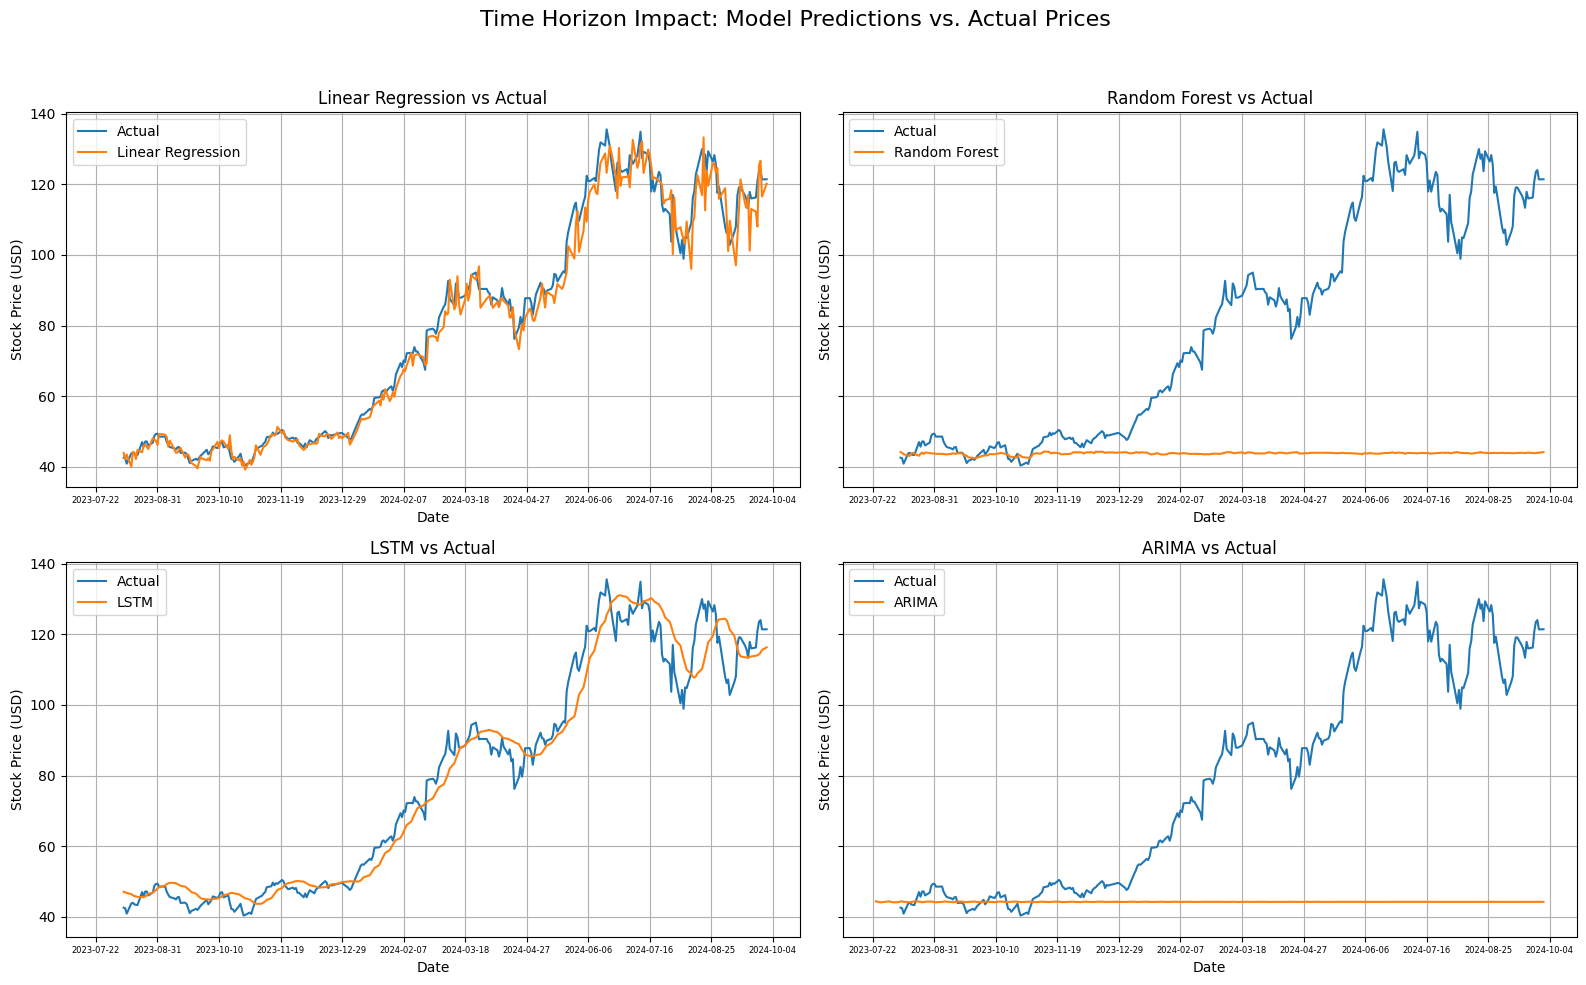

In [183]:
# Convert 'Date' column to datetime if it exists
if 'Date' in df_nvidia.columns:
    df_nvidia['Date'] = pd.to_datetime(df_nvidia['Date'], unit='ns', errors='coerce')
    df_nvidia.set_index('Date', inplace=True)

# Time Horizon Impact Linear Regression, Random Forests, LSTM, ARIMA
# Set up figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

# Plot Linear Regression
axs[0, 0].plot(df_nvidia.index[-len(y_test):], y_actual, label='Actual')
axs[0, 0].plot(df_nvidia.index[-len(y_test):], y_pred_lr_inv, label='Linear Regression')
axs[0, 0].set_title("Linear Regression vs Actual")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot Random Forest
axs[0, 1].plot(df_nvidia.index[-len(y_test):], y_actual, label='Actual')
axs[0, 1].plot(df_nvidia.index[-len(y_test):], y_pred_rf_inv, label='Random Forest')
axs[0, 1].set_title("Random Forest vs Actual")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot LSTM
axs[1, 0].plot(df_nvidia.index[-len(y_test):], y_actual, label='Actual')
axs[1, 0].plot(df_nvidia.index[-len(y_test):], y_pred.flatten(), label='LSTM')
axs[1, 0].set_title("LSTM vs Actual")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot ARIMA
axs[1, 1].plot(df_nvidia.index[-len(y_test):], y_actual, label='Actual')
axs[1, 1].plot(df_nvidia.index[-len(test):], forecast, label='ARIMA')
axs[1, 1].set_title("ARIMA vs Actual")
axs[1, 1].legend()
axs[1, 1].grid(True)

# Formatting
for ax in axs.flat:
    ax.set_xlabel("Date")
    ax.set_ylabel("Stock Price (USD)")
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))
    ax.tick_params(axis='x', labelsize=6)  # Set font size of x-axis dates
    ax.tick_params(labelbottom=True)

fig.suptitle("Time Horizon Impact: Model Predictions vs. Actual Prices", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('nvidia-time-horizon-prediction-comparison.png')
plt.show()